<a href="https://colab.research.google.com/github/chitimbwasc/chitimbwasc/blob/main/State_of_Art_Models_v0_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kaggle Dataset from [here](https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images)<br>
Notebook from [here](https://www.kaggle.com/code/uraninjo/state-of-art-models)

# Data Processing

In [ ]:
import os
DRIVE_PATH = '/content/drive/MyDrive/Omdena/NeuroAI/data/Alzheimer_s Dataset/'

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm
import time
import itertools

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow

from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101 # ResNet 101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3

import scipy
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))
# print("Num TPUs Available: ", len(tensorflow.config.list_physical_devices('TPU')))


# Set the seed value for experiment reproduci.bility.
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

In [ ]:
tick = time.perf_counter()

#define image dataset
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)


train_dataset = image_generator.flow_from_directory(batch_size=16,
                                                 directory=os.path.join(DRIVE_PATH+'train/'),
                                                 shuffle=True,
                                                 target_size=(224,224),
                                                 subset="training",
                                                 class_mode='categorical')

image_generator = ImageDataGenerator(rescale=1/255,validation_split=0.2)

validation_dataset = image_generator.flow_from_directory(batch_size=16,
                                                 directory=DRIVE_PATH+'test/',
                                                 shuffle=True,
                                                 target_size=(224,224),
                                                 class_mode='categorical')


submission = image_generator.flow_from_directory(
                                                 directory=DRIVE_PATH+'test/',
                                                 shuffle=False,
                                                subset="validation",
                                                 target_size=(224,224),
                                                 class_mode=None)

tock = time.perf_counter()
print(f'Time taken to load data: {tock-tick} seconds')

In [ ]:
#sample brain scans from the first batch

batch_1_img = train_dataset[0]
for i in range(0,2):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()

# helper funtions

In [ ]:
def subplots_from_history(history, model_name="Model"):
    # Extract metrics keys (excluding those starting with 'val_')
    metrics = [key for key in history.history.keys() if not key.startswith('val_')]

    # Calculate F1 Score and add it to the metrics list if precision and recall are available
    if 'precision' in metrics and 'recall' in metrics:
        precision = history.history['precision']
        recall = history.history['recall']
        f1_score = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(precision, recall)]  # Avoid division by zero

        val_precision = history.history['val_precision']
        val_recall = history.history['val_recall']
        val_f1_score = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(val_precision, val_recall)]

        history.history['f1_score'] = f1_score
        history.history['val_f1_score'] = val_f1_score

    # Calculate layout of subplots (grid)
    n_metrics = len(metrics)
    cols = 2  # Adjust the number of columns
    rows = (n_metrics + cols - 1) // cols  # Integer division for rows

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(8, 3 * rows))
    axes = axes.flatten()  # Flatten to iterate for the case of multiple rows and columns

    # Iterate over metrics and create subplots
    for i, metric in enumerate(metrics):
        val_metric = f"val_{metric}"

        # Plot training metric
        axes[i].plot(history.history[metric], label=f'train')

        # Plot validation metric
        if val_metric in history.history:
          axes[i].plot(history.history[val_metric], label=f'val')

        # Add title, labels and legend
        axes[i].set_title(f"{model_name if model_name[0] == 'M' else model_name+' Model'} {metric.capitalize()}")
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend(loc='upper left')

    # Hide any unused subplots
    for i in range(n_metrics, len(axes)):
        axes[i].axis('off')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def model_perf(data_generator, model, visualize=True, label="Training"):
  perf_dict = {}
  metrics_fn = ['accuracy_score', 'recall_score', 'precision_score', 'f1_score', 'roc_auc_score']
  if label != "Training": metrics = ['val_'+met for met in metrics_fn]
  else: metrics = metrics_fn

  # Make sure the generator is reset before prediction
  data_generator.reset()

  tick = time.perf_counter()
  predictions = model.predict(data_generator)
  predicted_classes = np.argmax(predictions, axis=1)
  tock = time.perf_counter()
  perf_dict[f'{label}_inference_time_in_secs'] = (tock-tick)
  perf_dict[f'{label}_inference_time_in_mins'] = (tock-tick)/60.0
  perf_dict[f'{label}_inference_count'] = len(predicted_classes)

  # True labels
  true_classes = data_generator.classes
  class_labels = list(data_generator.class_indices.keys())

  # Performance Metrics Calculation
  # print(f'Model Performance Metrics ({label}):')
  # for metric, metric_fn in zip(metrics, metrics_fn):
  #   metric_func = globals()[metric_fn]
  #   perf_dict[metric] = metric_func(class_labels, predicted_classes)
  #   print(f'{metric}: {perf_dict[metric]}')

  # print('-'*25)
  # Classification report
  print(f"Classification Report ({label} Set):")
  print(classification_report(true_classes, predicted_classes, target_names=class_labels))

  # Confusion matrix
  cm = confusion_matrix(true_classes, predicted_classes)
  print(f"Confusion Matrix ({label} Set):")
  if visualize:
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cm, class_labels)
    plt.show()
  else: print(cm)

  return perf_dict

In [ ]:
# model meta data and perf metrics
all_models_info = []

# VGG19

In [ ]:
this_model_info = dict()
this_model_info['model_name'] = 'VGG19'

vgg = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg19 = Model(inputs=vgg.input, outputs=prediction)
this_model_info['total_param'] = modelvgg19.count_params
modelvgg19.summary()

In [ ]:
modelvgg19.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc',
         keras.metrics.Precision(name='precision'),
         keras.metrics.Recall(name='recall')])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

In [ ]:
tick = time.perf_counter()
history_vgg19 = modelvgg19.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)
tock = time.perf_counter()

In [ ]:
time_vgg19 = (tock-tick)
this_model_info['train_time_in_secs'] = time_vgg19
this_model_info['train_time_in_mins'] = time_vgg19/60.0
print(f"Time to train {this_model_info['model_name']} model:\n{(time_vgg19)} secs\n{(time_vgg19/60.0)} mins")

In [ ]:
loss, auc, accuracy, precision, recall = modelvgg19.evaluate(validation_dataset)


In [ ]:
print(history_vgg19.history.keys())

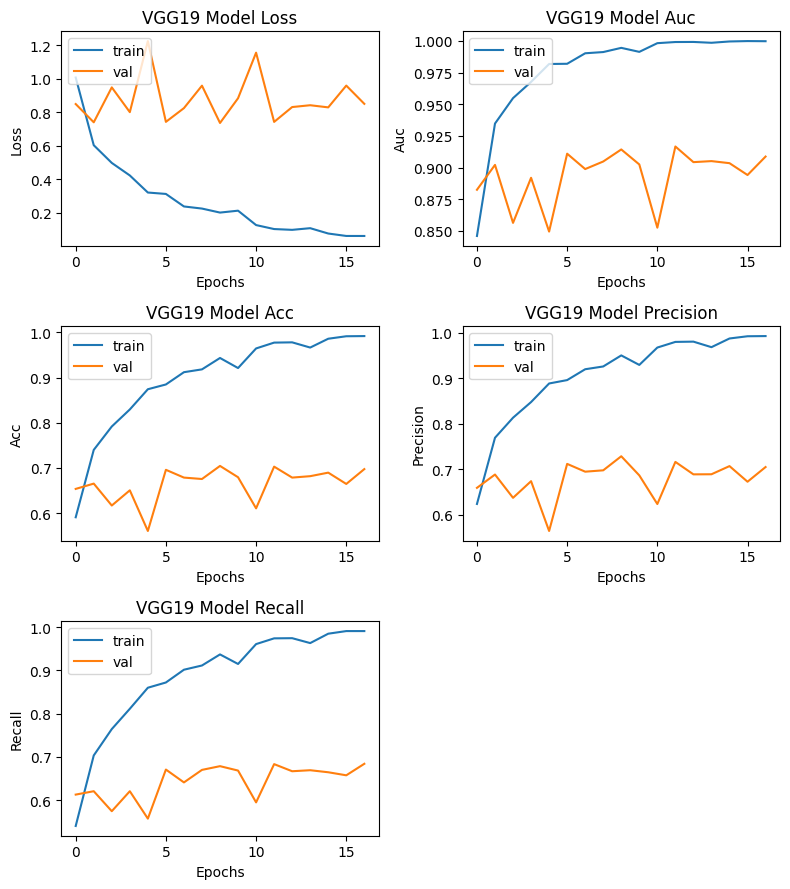

In [ ]:
subplots_from_history(history_vgg19, model_name='VGG19')

321/321 [==============================] - 23s 72ms/step
Classification Report (Training Set):
                  precision    recall  f1-score   support

    MildDemented       0.15      0.16      0.16       717
ModerateDemented       0.00      0.00      0.00        52
     NonDemented       0.51      0.52      0.51      2560
VeryMildDemented       0.36      0.33      0.35      1792

        accuracy                           0.40      5121
       macro avg       0.25      0.25      0.25      5121
    weighted avg       0.40      0.40      0.40      5121

Confusion Matrix (Training Set):


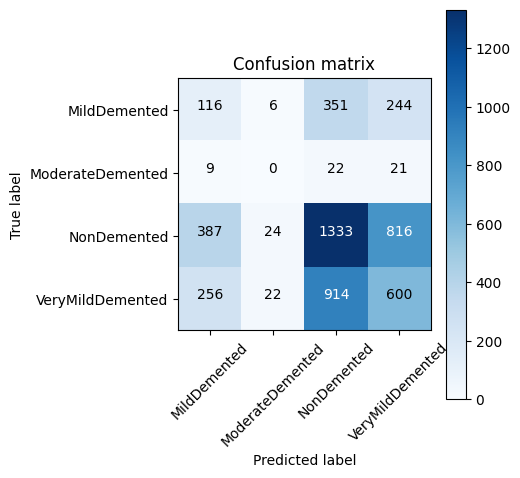

In [ ]:
this_model_perf_dict = model_perf(train_dataset, modelvgg19)
this_model_info.update(this_model_perf_dict)

80/80 [==============================] - 6s 71ms/step
Classification Report (Validation Set):
                  precision    recall  f1-score   support

    MildDemented       0.16      0.15      0.15       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.49      0.53      0.51       640
VeryMildDemented       0.34      0.31      0.33       448

        accuracy                           0.40      1279
       macro avg       0.25      0.25      0.25      1279
    weighted avg       0.39      0.40      0.39      1279

Confusion Matrix (Validation Set):


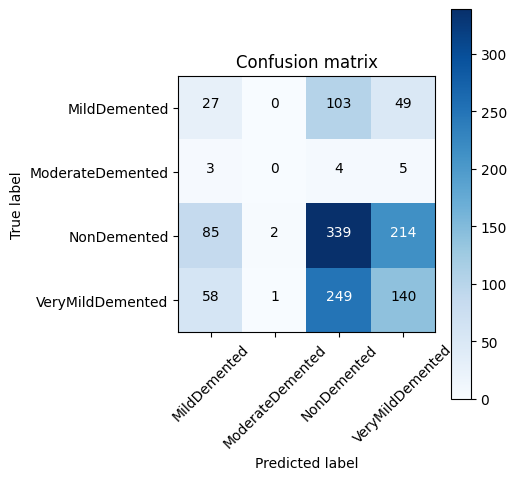

In [ ]:
this_model_perf_dict = model_perf(validation_dataset, modelvgg19, label="Validation")
this_model_info.update(this_model_perf_dict)